In [66]:
import timeit
import neater_cnc_tableau as cnc
import numpy as np

In [ ]:
import numpy as np
import timeit
from random import choice

# Assuming `CncSimulator`, `generate_gate_sequence`, and `apply_sequence_of_clifford` 
# are already defined elsewhere.

def generate_gate_sequence(n, beta):
    """Generate a random sequence of Clifford gates."""
    num_gates = int(beta * n * np.log2(n))
    gates = ['h', 's', 'cnot']
    sequence = []
    for _ in range(num_gates):
        gate = choice(gates)
        if gate == 'h' or gate == 's':  # Single qubit gates
            qubit = np.random.randint(0, n)
            sequence.append(f"{gate}_{qubit}")
        elif gate == 'cnot':  # Two-qubit gate
            control = np.random.randint(0, n)
            target = np.random.randint(0, n)
            while target == control:  # Ensure control != target
                target = np.random.randint(0, n)
            sequence.append(f"{gate}_{control}_{target}")
    return sequence

def apply_sequence_of_clifford(simulator, sequence):
    """Apply a sequence of Clifford gates to the simulator."""
    for gate in sequence:
        if gate.startswith('h'):
            qubit = int(gate.split('_')[1])
            simulator.apply_hadamard(qubit)
        elif gate.startswith('s'):
            qubit = int(gate.split('_')[1])
            simulator.apply_phase(qubit)
        elif gate.startswith('cnot'):
            control, target = map(int, gate.split('_')[1:])
            simulator.apply_cnot(control, target)


In [ ]:
# Loop over beta and n ranges
beta_values = np.arange(0.6, 1.4, 0.2)  # Beta from 0.6 to 1.2
n_values = range(200, 1401, 100)  # n from 200 to 2000

results = []

for beta in beta_values:
    for n in n_values:
        print(f"Running simulation for beta={beta:.1f}, n={n}")

        # Generate Clifford gate sequence
        sequence = generate_gate_sequence(n, beta)

        # Initialize the CNC simulator
        m = 100  # Adjust m as necessary
        simulator = cnc.CncSimulator(n, m)

        # Apply the gate sequence
        apply_sequence_of_clifford(simulator, sequence)

        # Prepare measurement bases
        zero_matrix = np.zeros((n, n), dtype=int)
        identity_matrix = np.eye(n, dtype=int)
        measurement_bases = np.hstack((identity_matrix,zero_matrix))

        # Define the setup code
        setup_code = f"""
import numpy as np
from __main__ import simulator, measurement_bases
"""

        # Define the statement to measure
        stmt_code = """
for base in range(measurement_bases.shape[0]):
    simulator.measure(measurement_bases[base, :])
"""

        # Time the execution
        repeat = 2
        execution_time = timeit.timeit(stmt=stmt_code, setup=setup_code, number=repeat)
        avg_time = execution_time /repeat
        print(f"Average time per iteration for beta={beta:.1f}, n={n}: {avg_time:.6f} seconds")

        # Store results
        results.append((beta, n, avg_time))

# Print all results
for beta, n, avg_time in results:
    print(f"Beta={beta:.1f}, n={n}, Avg Time={avg_time:.6f} seconds")


Running simulation for beta=0.6, n=200
Average time per iteration for beta=0.6, n=200: 0.128570 seconds
Running simulation for beta=0.6, n=300
Average time per iteration for beta=0.6, n=300: 0.459014 seconds
Running simulation for beta=0.6, n=400
Average time per iteration for beta=0.6, n=400: 0.890131 seconds
Running simulation for beta=0.6, n=500
Average time per iteration for beta=0.6, n=500: 1.720316 seconds
Running simulation for beta=0.6, n=600
Average time per iteration for beta=0.6, n=600: 2.199750 seconds
Running simulation for beta=0.6, n=700
Average time per iteration for beta=0.6, n=700: 3.422845 seconds
Running simulation for beta=0.6, n=800
Average time per iteration for beta=0.6, n=800: 5.324999 seconds
Running simulation for beta=0.6, n=900
Average time per iteration for beta=0.6, n=900: 7.979264 seconds
Running simulation for beta=0.6, n=1000
Average time per iteration for beta=0.6, n=1000: 10.705341 seconds
Running simulation for beta=0.6, n=1100
Average time per iter

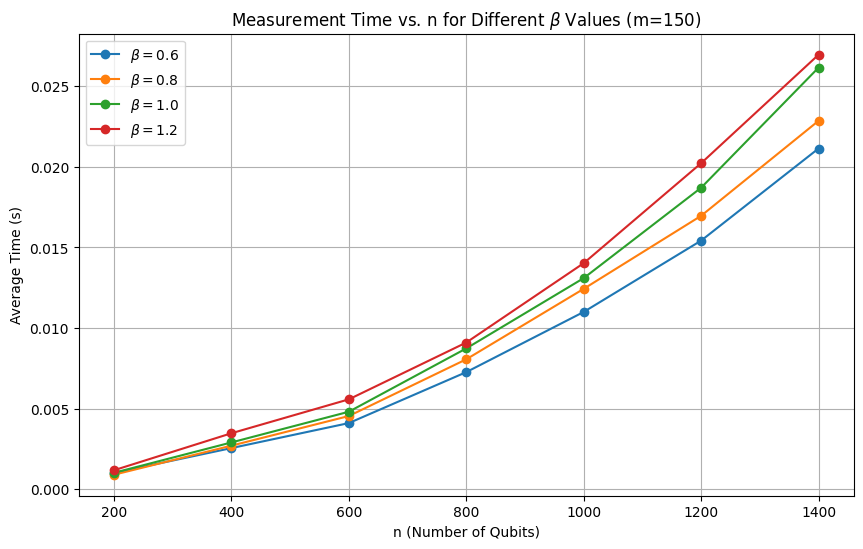

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Your numpy array
data = np.array(results)

# Extract unique beta values
betas = np.unique(data[:, 0])

# Create the plot
plt.figure(figsize=(10, 6))

for beta in betas:
    subset = data[data[:, 0] == beta]  # Filter rows with the current beta
    n = subset[:, 1]
    avg_time = subset[:, 2]/n
    plt.plot(n, avg_time, marker='o', label=f"$\\beta={round(beta,1)}$")  # LaTeX syntax for beta

# Label the axes and add a legend
plt.xlabel("n (Number of Qubits)")
plt.ylabel("Average Time (s)")
plt.title(f"Measurement Time vs. n for Different $\\beta$ Values (m={m})")  # Use beta in title
plt.legend()
plt.grid(True)

# Save the plot to a file
plt.savefig(f"./figures/measurement_x_time_plot_m_{m}.png", format="png", dpi=300)

# Show the plot (optional)
plt.show()

# Save to .npy file
np.save(f"./data/measurement_x_times_m_{m}.npy", np.array(results))

In [ ]:
np.load(f"measurement_times_m_{m}.npy")

array([[6.00000000e-01, 2.00000000e+02, 1.48432875e-01],
       [6.00000000e-01, 4.00000000e+02, 1.03077658e+00],
       [6.00000000e-01, 6.00000000e+02, 2.21608833e+00],
       [6.00000000e-01, 8.00000000e+02, 5.60963154e+00],
       [6.00000000e-01, 1.00000000e+03, 1.04872530e+01],
       [6.00000000e-01, 1.20000000e+03, 1.80013207e+01],
       [6.00000000e-01, 1.40000000e+03, 2.84446254e+01],
       [6.00000000e-01, 1.60000000e+03, 4.35869617e+01],
       [8.00000000e-01, 2.00000000e+02, 1.39921125e-01],
       [8.00000000e-01, 4.00000000e+02, 1.00820717e+00],
       [8.00000000e-01, 6.00000000e+02, 2.46799488e+00],
       [8.00000000e-01, 8.00000000e+02, 6.37513088e+00],
       [8.00000000e-01, 1.00000000e+03, 1.25236298e+01],
       [8.00000000e-01, 1.20000000e+03, 1.91508560e+01],
       [8.00000000e-01, 1.40000000e+03, 3.15184923e+01],
       [8.00000000e-01, 1.60000000e+03, 4.75791983e+01],
       [1.00000000e+00, 2.00000000e+02, 1.52270000e-01],
       [1.00000000e+00, 4.00000

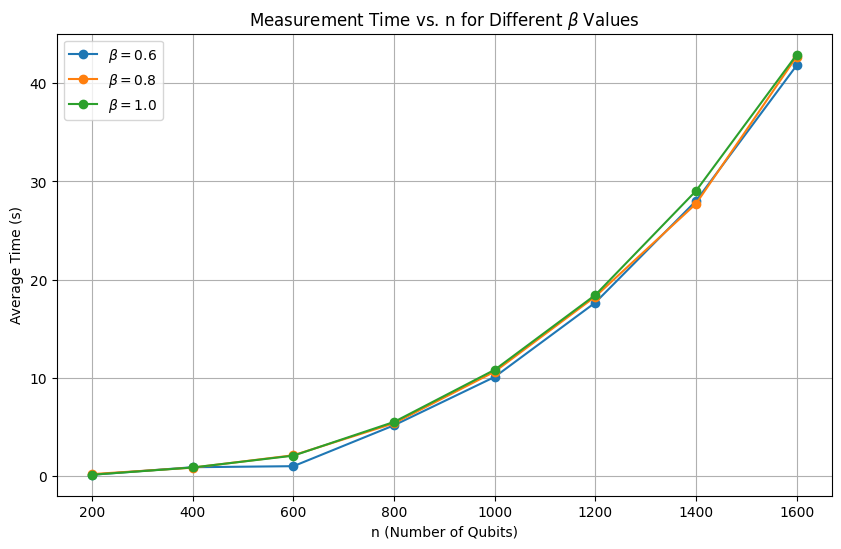

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# Your numpy array
data = np.load("measurement_times.npy")

# Extract unique beta values
betas = np.unique(data[:, 0])

# Create the plot
plt.figure(figsize=(10, 6))

for beta in betas:
    subset = data[data[:, 0] == beta]  # Filter rows with the current beta
    n = subset[:, 1]
    avg_time = subset[:, 2]
    plt.plot(n, avg_time, marker='o', label=f"$\\beta={beta}$")  # LaTeX syntax for beta

# Label the axes and add a legend
plt.xlabel("n (Number of Qubits)")
plt.ylabel("Average Time (s)")
plt.title("Measurement Time vs. n for Different $\\beta$ Values")  # Use beta in title
plt.legend()
plt.grid(True)

# Save the plot to a file
plt.savefig("measurement_time_plot.png", format="png", dpi=300)

# Show the plot (optional)
plt.show()
